In [3]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from src.utils import load
from src.preprocessing import DataSet
from src.forecast.cnn import datagen, f1macro, testgen, scale_inputs, precision_m, precision_loss
from src.forecast.clstm import CLSTMModel

from keras.layers import Input, Conv1D, Flatten, Dense, Dropout
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import accuracy_score, f1_score, mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error


pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 50)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



In [4]:

CURR = "EURUSD"
INTERVAL = "4h"

eurusd = load(currency=CURR, interval=INTERVAL)
data = DataSet(data=eurusd, ratios=[0.9, 0.1], label=['target_value'])
train, val, test = data.add_variables().clean_data().get_tvt_df()

train.drop(columns=['target_direction'], inplace=True)
test.drop(columns=['target_direction'], inplace=True)

# Construct LSTM part

In [52]:
from src.forecast.lstm import LSTM_

In [38]:
dg = datagen(df=train, 
                seq_len=10, 
                batch_size=64, 
                targetcol=['target_value'],
                kind="train")

In [62]:
model = LSTM_(
    activation='selu',
    target_col='target_value'
)
model.compile()
model.fit(train,
          epochs=2,
          steps_per_epoch=100)

Epoch 1/2
100/100 [==============================] - 16s 76ms/step - loss: 6.6434 - mean_absolute_error: 0.0825
Epoch 2/2
100/100 [==============================] - 7s 67ms/step - loss: 4.9326 - mean_absolute_error: 0.0590


48/48 [==============================] - 3s 34ms/step


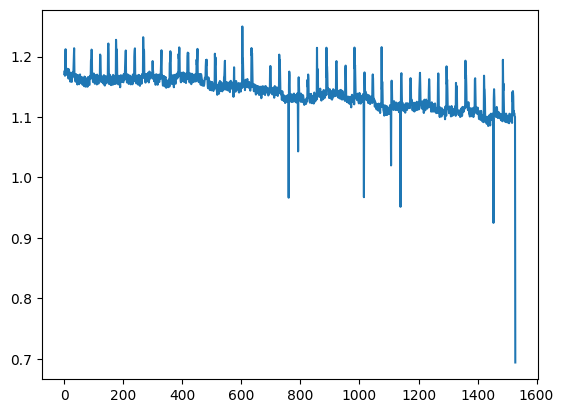

# Construct CNN part

In [3]:
from src.forecast.cnn import CNN_

In [49]:
model = CNN_(
    activation="selu"
)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.metrics.F1Score())
model.fit(train,
          epochs=5,
          steps_per_epoch=100)

NameError: name 'CNN_' is not defined

In [518]:
pred = model.predict(test)
res = pd.DataFrame({"pred": pred, "true": test.target_direction[10:]})
res

 1/48 [..............................] - ETA: 13s

2023-05-06 15:24:20.009131: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


48/48 [==============================] - 1s 9ms/step


,pred,true
Datetime,,
2021-11-09 04:00:00,0,0
2021-11-09 08:00:00,0,0
2021-11-09 12:00:00,0,0
2021-11-09 16:00:00,0,0
2021-11-10 00:00:00,0,1
...,...,...
2022-10-17 12:00:00,0,0
2022-10-17 16:00:00,0,0
2022-10-17 20:00:00,0,0


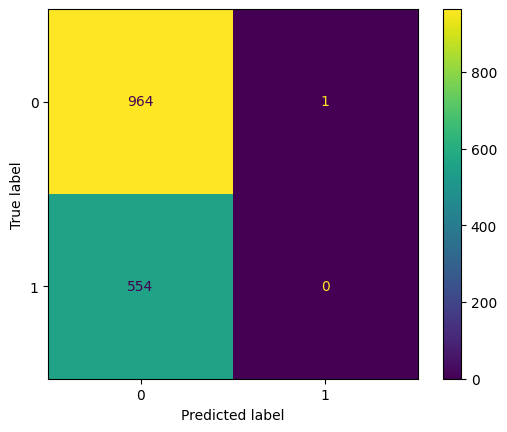

In [519]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(res.true, res.pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0, 1])
disp.plot()

# Combine both, train and evalute

In [9]:
model = CLSTMModel(
    nodes=[64, 32],
    # lstm_nodes=[16, 32, 32, 32],
    # lstm_activation='selu',
    # cnn_filters=4,
    # cnn_kernel_size=6,
    # cnn_activation='selu'
    # activation='selu',
    # seq_len=10,
)
model.compile()
model.fit(
    data=train,
    epochs=20,
    steps_per_epoch=100,
)

{'nodes': [16, 32, 32, 32], 'activation': 'relu'}
{'filters': 4, 'kernel_size': 6}
Epoch 1/20
100/100 [==============================] - 11s 73ms/step - loss: 22.3983 - mean_absolute_error: 0.3081
Epoch 2/20
100/100 [==============================] - 7s 65ms/step - loss: 1.2133 - mean_absolute_error: 0.0166
Epoch 3/20
100/100 [==============================] - 6s 64ms/step - loss: 1.2075 - mean_absolute_error: 0.0165
Epoch 4/20
100/100 [==============================] - 6s 64ms/step - loss: 1.2078 - mean_absolute_error: 0.0165
Epoch 5/20
100/100 [==============================] - 6s 64ms/step - loss: 1.2084 - mean_absolute_error: 0.0165
Epoch 6/20
100/100 [==============================] - 7s 65ms/step - loss: 1.2102 - mean_absolute_error: 0.0166
Epoch 7/20
100/100 [==============================] - 6s 65ms/step - loss: 1.2105 - mean_absolute_error: 0.0166
Epoch 8/20
100/100 [==============================] - 6s 64ms/step - loss: 1.2134 - mean_absolute_error: 0.0166
Epoch 9/20
100/100 

In [23]:
pred_y = model.predict(test)

48/48 [==============================] - 3s 32ms/step


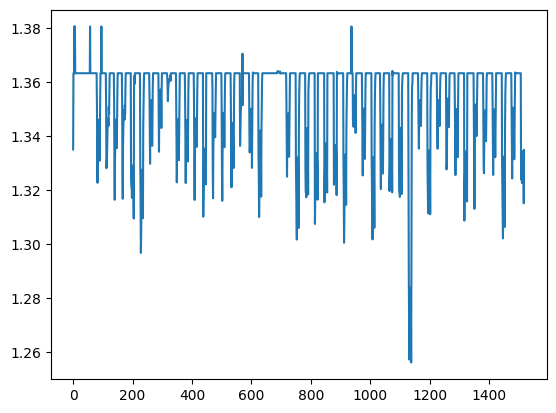